# $Import$

In [1]:
import random
from numba import njit
import numpy as np
import pymanopt
import autograd.numpy as anp
from pymanopt.manifolds import Product
from pymanopt.optimizers import TrustRegions
from datetime import datetime
import csv
import matplotlib.pyplot as plt

# $Function$ $functions$

## 1.Ising Model Matrix(complete)

In [2]:
def weight_matrix(nbit):
    mat = np.zeros((nbit, nbit))
    for ii in range(nbit):
        for jj in range(nbit):
            if jj >= ii: mat[ii, jj] = np.random.uniform(-1, 1)
    return mat

## 2.Save to csv file

In [3]:
def save_file(filename, data):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

## 3.Read csv file

In [4]:
def readcsv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        return [list(map(float, col)) for col in zip(*reader)]

## 4.Get the mean and std

In [5]:
def calculate(lst):
    arr = np.array(lst)
    mean = np.mean(arr)
    stddev = np.std(arr, ddof=1)
    return mean, stddev

## 5.Burer Monteiro method to Warm-Start

In [6]:
def burer_monteiro_method(W, c=3):
    nbit = len(W)
    Q = np.triu(W, k=1) + np.triu(W, k=1).T
    S = np.diag(W)
    Q_new = np.r_[np.c_[Q, S], [np.append(S, 1)]]

    # Define Product manifolds
    manifold = Product([pymanopt.manifolds.Sphere(c) for _ in range(nbit+1)])

    @pymanopt.function.autograd(manifold)
    # Define the cost function
    def objective(*X):
        X = anp.stack(X, axis=0)  # matrix form
        return anp.trace(Q_new @ (X @ X.T))

    problem = pymanopt.Problem(manifold, objective)
    optimizer = TrustRegions(max_iterations=1000, min_gradient_norm=1e-6, verbosity=0)
    result = optimizer.run(problem)
    X_opt = anp.stack(result.point, axis=0)
    return X_opt[:-1, :]

## 6.Get solution from X_opt

In [7]:
def get_value(X_opt, W, samples):
    n, c = X_opt.shape
    best_bits = None
    best_value = np.inf
    for _ in range(samples):
        r = np.random.randn(c)
        r /= np.linalg.norm(r)
        x = np.sign(X_opt @ r)
        value = 0
        for i in range(n):
            for j in range(i+1, n):
                value += 2 * x[i] * x[j] * W[i, j]
        for i in range(n):
            value += x[i] * W[i, i]
        if value < best_value:
            best_value = value
            best_bits = x.copy()
    return best_bits, best_value

# $Baseline$ $greedy$ $algorithm$

In [8]:
def example(nqubit, Q_triu, repeat):
    J = np.triu(Q_triu, k=1) + np.triu(Q_triu, k=1).T
    h = np.diag(Q_triu)
    best_energy = np.inf

    for ii in range(repeat):
        num1 = random.randint(0, nqubit)
        select_num = random.sample(range(nqubit), num1)
        
        bits = np.zeros(nqubit)

        for i in range(nqubit):
            if i in select_num:
                bits[i] = -1
            else:
                bits[i] = 1

        energy = h@bits + bits.T @ J @ bits

        while True:
            delta_E = (2*J @ bits + h) * -2 * bits
            index = np.argmin(delta_E)
            bits[index] = -bits[index]

            if delta_E[index] < 0:
                energy += delta_E[index]
            else:
                break

        if energy < best_energy:
            best_energy = energy
    return best_energy

# $Baseline$ $greedy$ $with$ $Warm-Start$

In [9]:
def example_ws(nqubit, Q_triu, bits):
    J = np.triu(Q_triu, k=1) + np.triu(Q_triu, k=1).T
    h = np.diag(Q_triu)
    best_energy = np.inf

    energy = h @ bits + bits.T @ J @ bits

    while True:
        delta_E = (2 * J @ bits + h) * -2 * bits
        index = np.argmin(delta_E)
        bits[index] = -bits[index]

        if delta_E[index] < 0:
            energy += delta_E[index]
        else:
            break

    if energy < best_energy:
        best_energy = energy
    return best_energy

# $Results$

### code

In [ ]:
task = [200, 400, 600, 800, 1000]

instances = 60
print("start:",datetime.now().strftime("%H:%M:%S"))
for nbit in task:
    lst = []
    for num in range(instances):
        W = weight_matrix(nbit)
        X_opt = burer_monteiro_method(W, 3)
        print(num+1, "optimize is done", datetime.now().strftime("%H:%M:%S"))

        bits, energy = get_value(X_opt, W, 1)
        energy_ws_0 = example_ws(nbit, W, bits)
        print(num+1, "sample=1 is done", datetime.now().strftime("%H:%M:%S"))
        bits, energy = get_value(X_opt, W, 10)
        energy_ws_1 = example_ws(nbit, W, bits)
        print(num+1, "sample=10 is done", datetime.now().strftime("%H:%M:%S"))
        bits, energy = get_value(X_opt, W, 100)
        energy_ws_2 = example_ws(nbit, W, bits)
        print(num+1, "sample=100 is done", datetime.now().strftime("%H:%M:%S"))
        bits, energy = get_value(X_opt, W, 1000)
        energy_ws_3 = example_ws(nbit, W, bits)
        print(num+1, "sample=1000 is done", datetime.now().strftime("%H:%M:%S"))
        bits, energy = get_value(X_opt, W, 10000)
        energy_ws_4 = example_ws(nbit, W, bits)
        print(num+1, "sample=10000 is done", datetime.now().strftime("%H:%M:%S"))

        energy_0 = example(nbit, W, repeat=1)
        print(num+1, "repeat=1 is done", datetime.now().strftime("%H:%M:%S"))
        energy_1 = example(nbit, W, repeat=10)
        print(num+1, "repeat=10 is done", datetime.now().strftime("%H:%M:%S"))
        energy_2 = example(nbit, W, repeat=100)
        print(num+1, "repeat=100 is done", datetime.now().strftime("%H:%M:%S"))
        energy_3 = example(nbit, W, repeat=1000)
        print(num+1, "repeat=1000 is done", datetime.now().strftime("%H:%M:%S"))
        lst.append([energy_ws_0, energy_ws_1, energy_ws_2, energy_ws_3, energy_ws_4, energy_0, energy_1, energy_2, energy_3])
    save_file(f"ws_n={nbit}.csv", lst)

### run my data

In [10]:
task = [200, 400, 600, 800, 1000]

lsts = [readcsv(f"ws_n={i}.csv") for i in task]

aves = [[], [], [], [], [], [], [], [], []]
yerrs = [[], [], [], [], [], [], [], [], []]

for j in range(5):
    for i in range(9):
        ave, yerr = calculate(lsts[j][i])
        aves[i].append(ave/task[j])
        yerrs[i].append(yerr/task[j])

s0_ave = aves[0]
s1_ave = aves[1]
s2_ave = aves[2]
s3_ave = aves[3]
s4_ave = aves[4]
r0_ave = aves[5]
r1_ave = aves[6]
r2_ave = aves[7]
r3_ave = aves[8]

s0_yerr = yerrs[0]
s1_yerr = yerrs[1]
s2_yerr = yerrs[2]
s3_yerr = yerrs[3]
s4_yerr = yerrs[4]
r0_yerr = yerrs[5]
r1_yerr = yerrs[6]
r2_yerr = yerrs[7]
r3_yerr = yerrs[8]

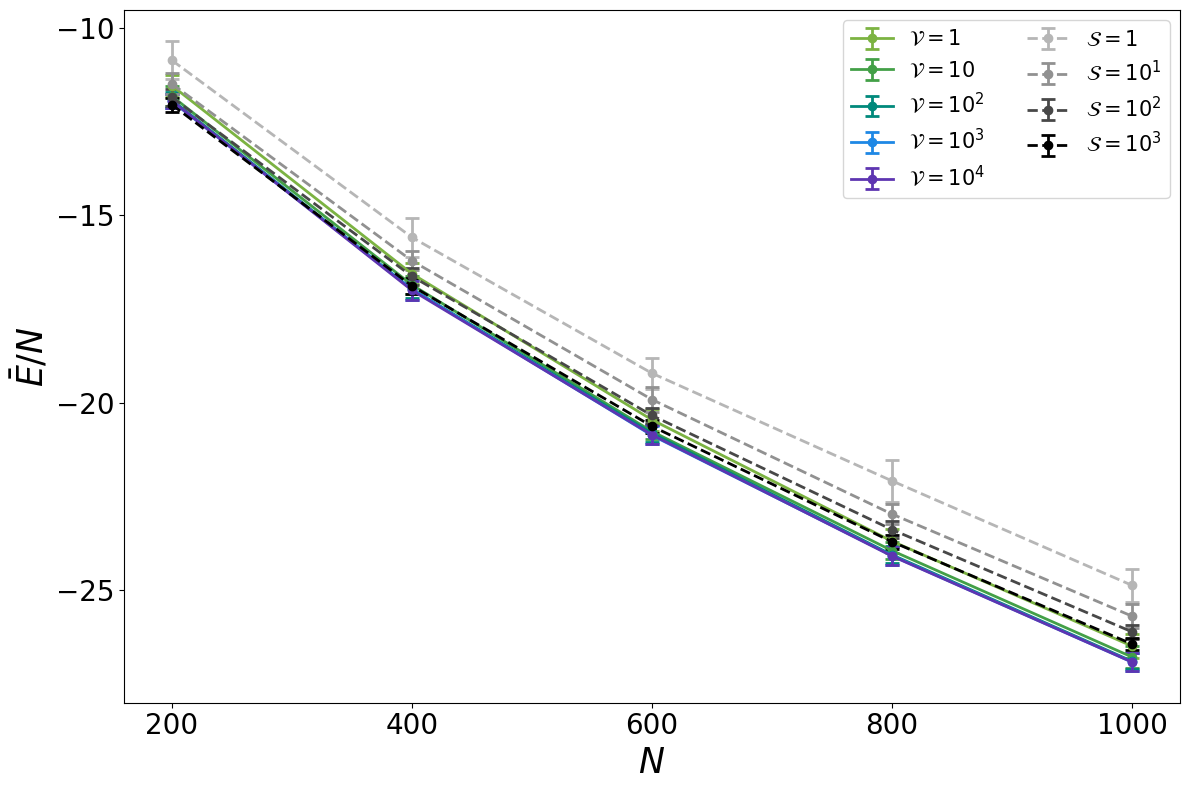

In [11]:
colors_s = ['#7CB342', '#43A047', '#00897B', '#1E88E5', '#5E35B1']
colors = [f"#{i:02x}{i:02x}{i:02x}" for i in np.linspace(0, 255,8).astype(int)]
plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-10, -15, -20, -25], fontsize=20)
plt.errorbar(task, s0_ave, yerr=s0_yerr, fmt="o", linestyle="-", lw=2, ecolor=colors_s[0], capsize=5, capthick=2, color=colors_s[0], label=r"$\mathcal{V}=1$")
plt.errorbar(task, s1_ave, yerr=s1_yerr, fmt="o", linestyle="-", lw=2, ecolor=colors_s[1], capsize=5, capthick=2, color=colors_s[1], label=r"$\mathcal{V}=10$")
plt.errorbar(task, s2_ave, yerr=s2_yerr, fmt="o", linestyle="-", lw=2, ecolor=colors_s[2], capsize=5, capthick=2, color=colors_s[2], label=r"$\mathcal{V}=10^{2}$")
plt.errorbar(task, s3_ave, yerr=s3_yerr, fmt="o", linestyle="-", lw=2, ecolor=colors_s[3], capsize=5, capthick=2, color=colors_s[3], label=r"$\mathcal{V}=10^{3}$")
plt.errorbar(task, s4_ave, yerr=s4_yerr, fmt="o", linestyle="-", lw=2, ecolor=colors_s[4], capsize=5, capthick=2, color=colors_s[4], label=r"$\mathcal{V}=10^{4}$")
plt.errorbar(task, r0_ave, yerr=r0_yerr, fmt="o", linestyle="--", lw=2, ecolor=colors[5], capsize=5, capthick=2, color=colors[5], label=r"$\mathcal{S}=1$")
plt.errorbar(task, r1_ave, yerr=r1_yerr, fmt="o", linestyle="--", lw=2, ecolor=colors[4], capsize=5, capthick=2, color=colors[4], label=r"$\mathcal{S}=10^1$")
plt.errorbar(task, r2_ave, yerr=r2_yerr, fmt="o", linestyle="--", lw=2, ecolor=colors[2], capsize=5, capthick=2, color=colors[2], label=r"$\mathcal{S}=10^2$")
plt.errorbar(task, r3_ave, yerr=r3_yerr, fmt="o", linestyle="--", lw=2, ecolor="black", capsize=5, capthick=2, color="black", label=r"$\mathcal{S}=10^3$")
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$\bar{E}/N$", fontsize=25)
plt.legend(fontsize=15, ncol=2)
plt.tight_layout()
plt.show()

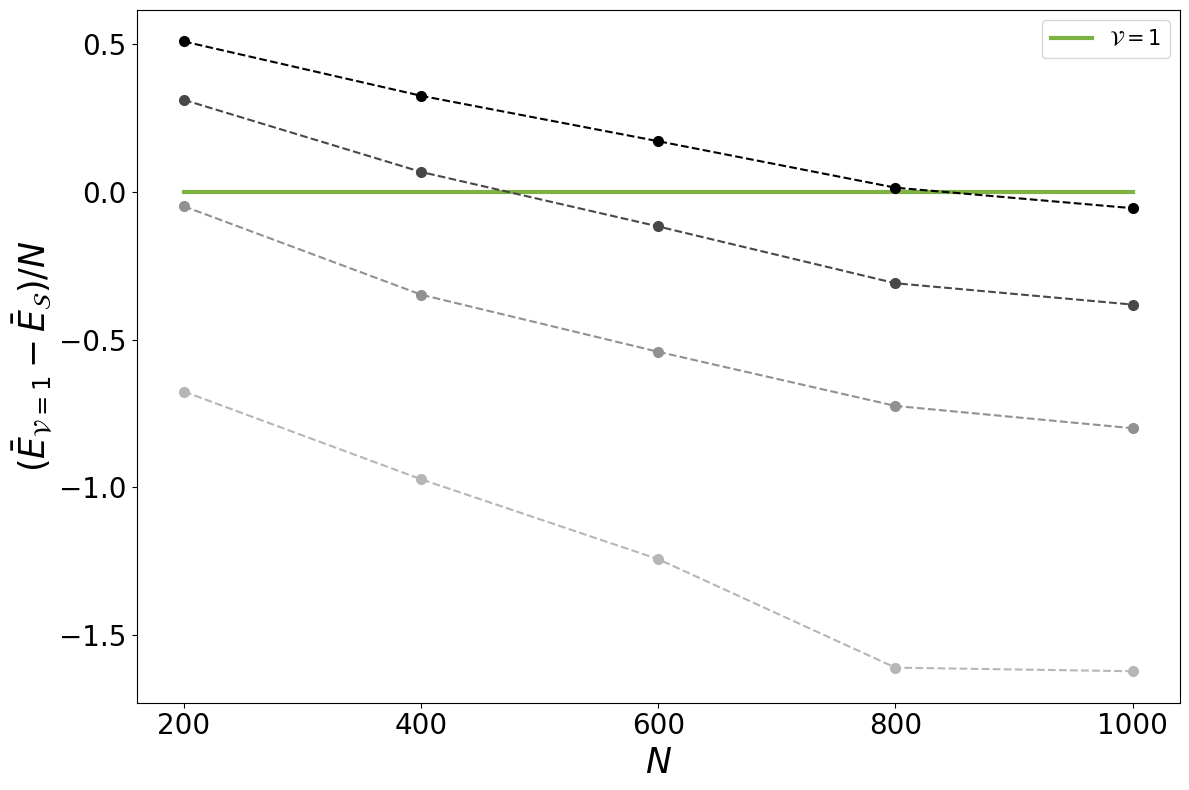

In [12]:
s0_diff_0 = [s0_ave[i] - r0_ave[i] for i in range(5)]
s0_diff_1 = [s0_ave[i] - r1_ave[i] for i in range(5)]
s0_diff_2 = [s0_ave[i] - r2_ave[i] for i in range(5)]
s0_diff_3 = [s0_ave[i] - r3_ave[i] for i in range(5)]
plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-1.5, -1.0, -0.5, 0, 0.5], fontsize=20)
plt.plot(task,np.full_like(task,0),color=colors_s[0],linestyle='-',linewidth=3, label=r"$\mathcal{V}=1$")
plt.plot(task, s0_diff_0, color=colors[5], linestyle='--',marker='o', markersize=7)
plt.plot(task, s0_diff_1, color=colors[4], linestyle='--',marker='o', markersize=7)
plt.plot(task, s0_diff_2, color=colors[2], linestyle='--',marker='o', markersize=7)
plt.plot(task, s0_diff_3, color="black", linestyle='--',marker='o', markersize=7)
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$(\bar{E}_{\mathcal{V}=1}-\bar{E}_{\mathcal{S}})/N$", fontsize=25)
plt.tight_layout()
plt.legend(fontsize=15)
plt.show()

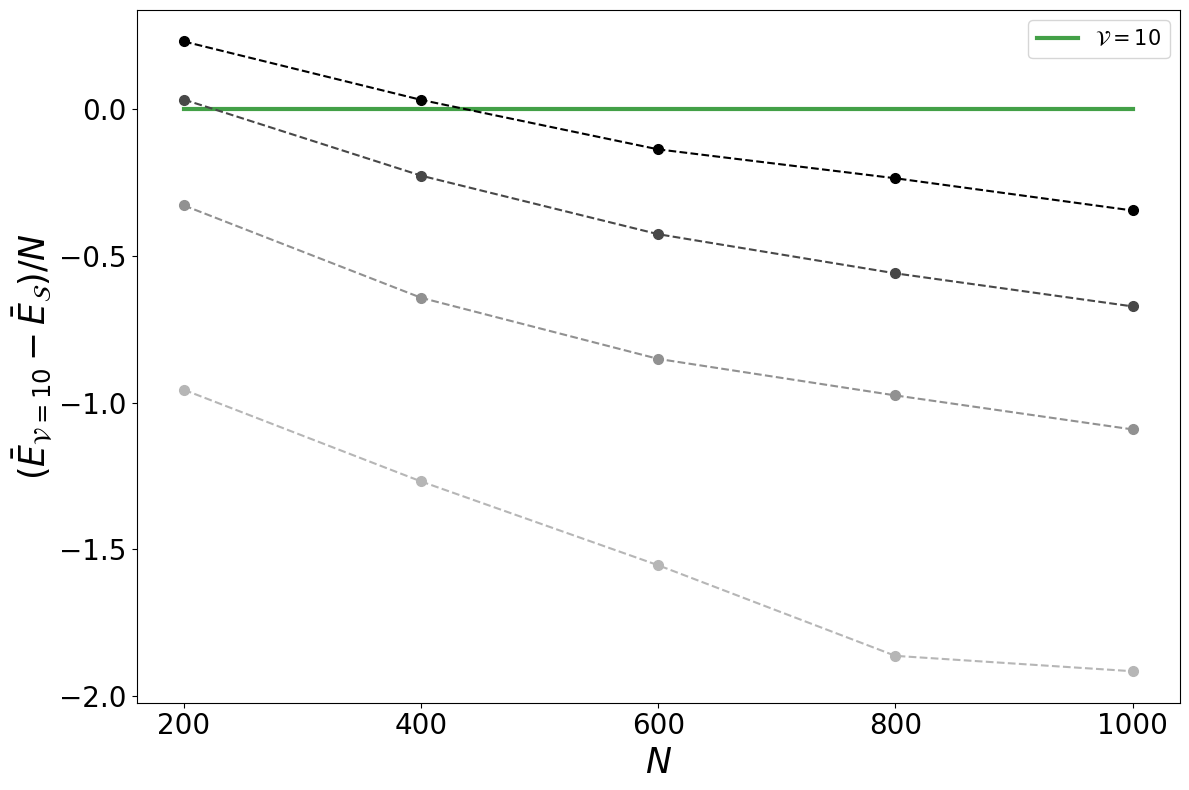

In [13]:
s1_diff_0 = [s1_ave[i] - r0_ave[i] for i in range(5)]
s1_diff_1 = [s1_ave[i] - r1_ave[i] for i in range(5)]
s1_diff_2 = [s1_ave[i] - r2_ave[i] for i in range(5)]
s1_diff_3 = [s1_ave[i] - r3_ave[i] for i in range(5)]
plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-2.0, -1.5, -1.0, -0.5, 0], fontsize=20)
plt.plot(task,np.full_like(task,0),color=colors_s[1],linestyle='-',linewidth=3, label=r"$\mathcal{V}=10$")
plt.plot(task, s1_diff_0, color=colors[5], linestyle='--',marker='o', markersize=7)
plt.plot(task, s1_diff_1, color=colors[4], linestyle='--',marker='o', markersize=7)
plt.plot(task, s1_diff_2, color=colors[2], linestyle='--',marker='o', markersize=7)
plt.plot(task, s1_diff_3, color="black", linestyle='--',marker='o', markersize=7)
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$(\bar{E}_{\mathcal{V}=10}-\bar{E}_{\mathcal{S}})/N$", fontsize=25)
plt.tight_layout()
plt.legend(fontsize=15)
plt.show()

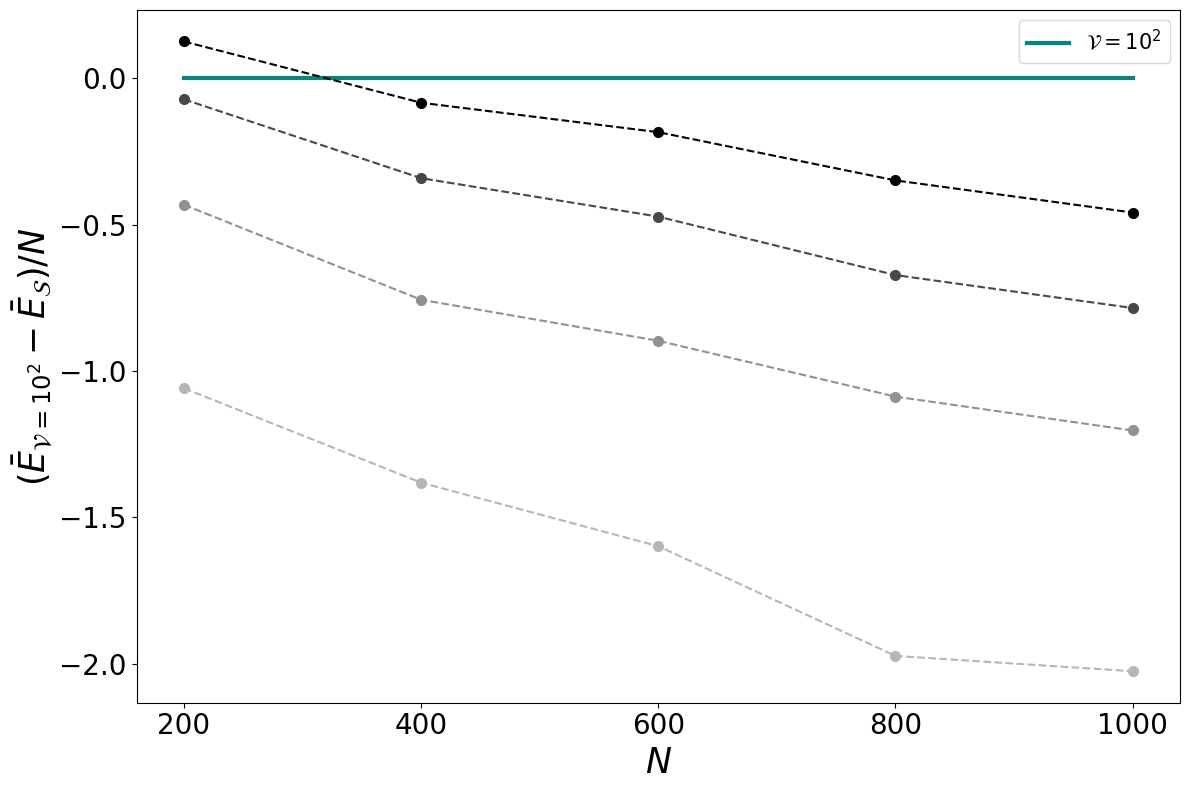

In [14]:
s2_diff_0 = [s2_ave[i] - r0_ave[i] for i in range(5)]
s2_diff_1 = [s2_ave[i] - r1_ave[i] for i in range(5)]
s2_diff_2 = [s2_ave[i] - r2_ave[i] for i in range(5)]
s2_diff_3 = [s2_ave[i] - r3_ave[i] for i in range(5)]
plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-2.0, -1.5, -1.0, -0.5, 0], fontsize=20)
plt.plot(task,np.full_like(task,0),color=colors_s[2],linestyle='-',linewidth=3, label=r"$\mathcal{V}=10^2$")
plt.plot(task, s2_diff_0, color=colors[5], linestyle='--',marker='o', markersize=7)
plt.plot(task, s2_diff_1, color=colors[4], linestyle='--',marker='o', markersize=7)
plt.plot(task, s2_diff_2, color=colors[2], linestyle='--',marker='o', markersize=7)
plt.plot(task, s2_diff_3, color="black", linestyle='--',marker='o', markersize=7)
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$(\bar{E}_{\mathcal{V}=10^2}-\bar{E}_{\mathcal{S}})/N$", fontsize=25)
plt.tight_layout()
plt.legend(fontsize=15)
plt.show()

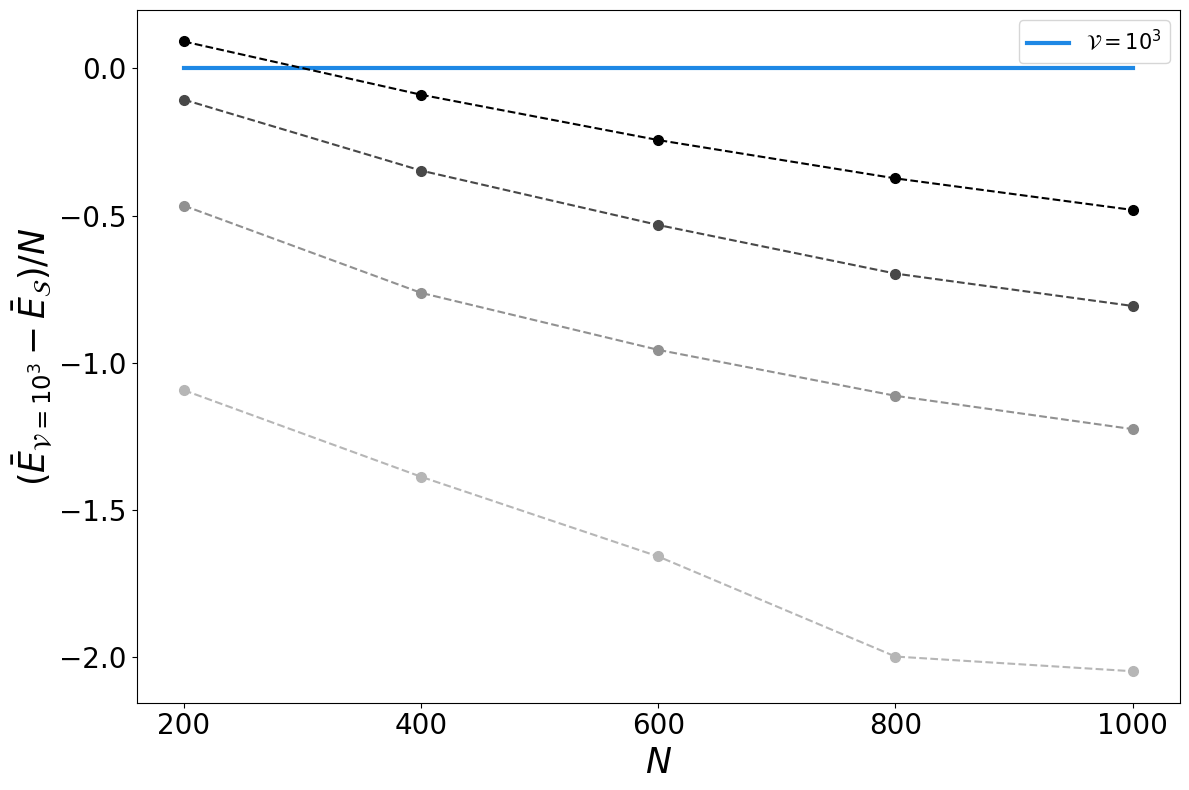

In [15]:
s3_diff_0 = [s3_ave[i] - r0_ave[i] for i in range(5)]
s3_diff_1 = [s3_ave[i] - r1_ave[i] for i in range(5)]
s3_diff_2 = [s3_ave[i] - r2_ave[i] for i in range(5)]
s3_diff_3 = [s3_ave[i] - r3_ave[i] for i in range(5)]
plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-2.0, -1.5, -1.0, -0.5, 0], fontsize=20)
plt.plot(task,np.full_like(task,0),color=colors_s[3],linestyle='-',linewidth=3, label=r"$\mathcal{V}=10^3$")
plt.plot(task, s3_diff_0, color=colors[5], linestyle='--',marker='o', markersize=7)
plt.plot(task, s3_diff_1, color=colors[4], linestyle='--',marker='o', markersize=7)
plt.plot(task, s3_diff_2, color=colors[2], linestyle='--',marker='o', markersize=7)
plt.plot(task, s3_diff_3, color="black", linestyle='--',marker='o', markersize=7)
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$(\bar{E}_{\mathcal{V}=10^3}-\bar{E}_{\mathcal{S}})/N$", fontsize=25)
plt.tight_layout()
plt.legend(fontsize=15)
plt.show()

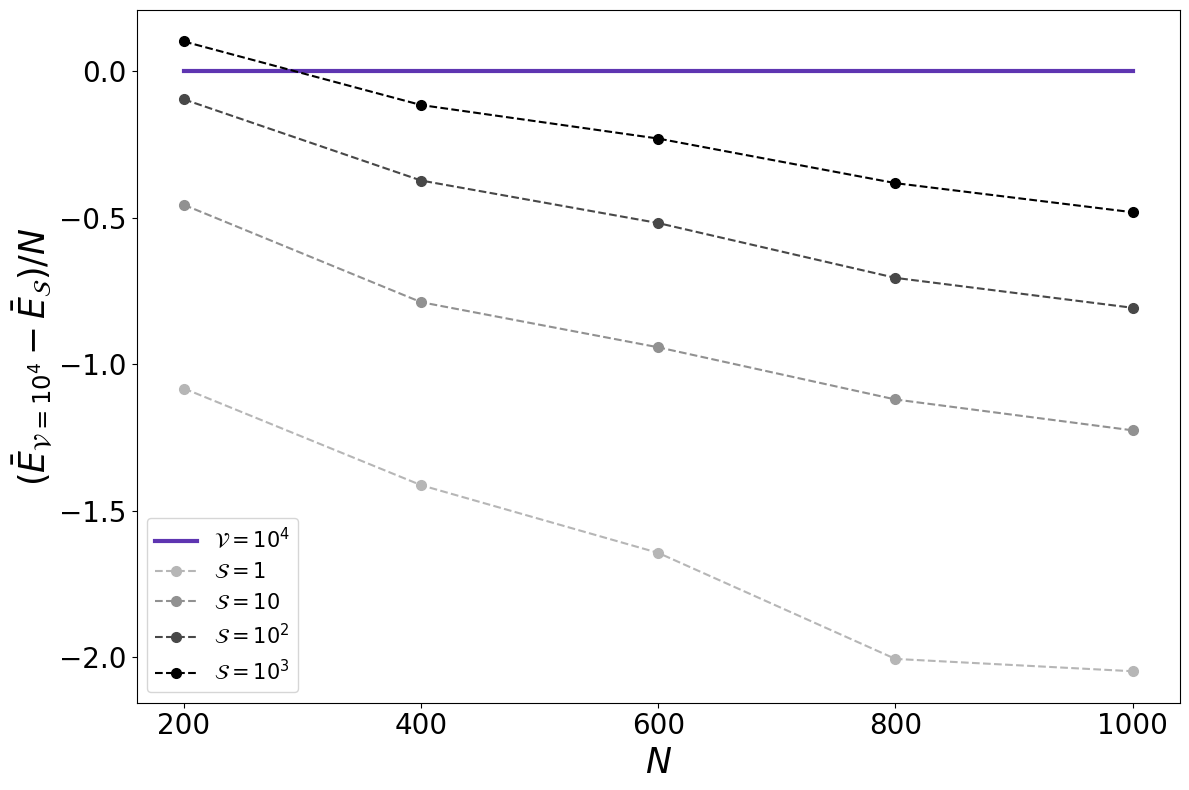

In [16]:
s4_diff_0 = [s4_ave[i] - r0_ave[i] for i in range(5)]
s4_diff_1 = [s4_ave[i] - r1_ave[i] for i in range(5)]
s4_diff_2 = [s4_ave[i] - r2_ave[i] for i in range(5)]
s4_diff_3 = [s4_ave[i] - r3_ave[i] for i in range(5)]
plt.figure(figsize=(12,8))
plt.xticks(task, fontsize=20)
plt.yticks([-2.0, -1.5, -1.0, -0.5, 0], fontsize=20)
plt.plot(task,np.full_like(task,0),color=colors_s[4],linestyle='-',linewidth=3, label=r"$\mathcal{V}=10^4$")
plt.plot(task, s4_diff_0, color=colors[5], linestyle='--',marker='o', markersize=7, label=r"$\mathcal{S}=1$")
plt.plot(task, s4_diff_1, color=colors[4], linestyle='--',marker='o', markersize=7, label=r"$\mathcal{S}=10$")
plt.plot(task, s4_diff_2, color=colors[2], linestyle='--',marker='o', markersize=7, label=r"$\mathcal{S}=10^2$")
plt.plot(task, s4_diff_3, color="black", linestyle='--',marker='o', markersize=7, label=r"$\mathcal{S}=10^3$")
plt.xlabel(r"$N$", fontsize=25)
plt.ylabel(r"$(\bar{E}_{\mathcal{V}=10^4}-\bar{E}_{\mathcal{S}})/N$", fontsize=25)
plt.tight_layout()
plt.legend(fontsize=15)
plt.show()